In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/
time: 19.1 s (started: 2022-02-03 03:27:54 +00:00)


In [3]:
#read from csv to avoid long running lemmatizing process
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Amazon_Product_Review/data.csv")

time: 10.2 s (started: 2022-02-03 03:28:19 +00:00)


In [4]:
df.head()

,asin,overall,reviewText_len,reviewTime,review,sentiment,review_no_punct,lemmatized_review
0,0000031887,5.0,172,2011-02-12,This is a great tutu and at a really great pri...,pos,this is a great tutu and at a really great pri...,great tutu really great price doesnt look chea...
1,0000031887,5.0,306,2013-01-19,I bought this for my 4 yr old daughter for dan...,pos,i bought this for my 4 yr old daughter for dan...,bought 4 yr old daughter dance class wore toda...
2,0000031887,5.0,312,2013-01-04,What can I say... my daughters have it in oran...,pos,what can i say my daughters have it in orange ...,say daughter orange black white pink thinking ...
3,0000031887,5.0,405,2014-04-27,"We bought several tutus at once, and they are ...",pos,we bought several tutus at once and they are g...,bought several tutu got high review sturdy see...
4,0000031887,5.0,453,2014-03-15,Thank you Halo Heaven great product for Little...,pos,thank you halo heaven great product for little...,thank halo heaven great product little girl gr...


time: 54.9 ms (started: 2022-02-03 03:28:32 +00:00)


In [8]:
df["lemmatized_review"][0]

'great tutu really great price doesnt look cheap im glad looked amazon found affordable tutu isnt made poorly great tutu cheaply made'

time: 8.7 ms (started: 2022-02-03 03:31:45 +00:00)


# Model Training

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

def get_X_y(df):
    y = df.sentiment
    X = df.lemmatized_review
    y = np.array(list(map(lambda x: 1 if x == "pos" else 0, y)))
    return X, y

time: 728 ms (started: 2022-02-03 03:29:47 +00:00)


In [20]:
def get_train_test_split(X, y):
  return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

time: 1.07 ms (started: 2022-02-03 03:42:41 +00:00)


In [21]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def tokenize_lines(text):
  return nltk.word_tokenize(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
time: 55.7 ms (started: 2022-02-03 03:42:49 +00:00)


In [22]:
def tokenize(review):
  review = tokenize_lines(review)
  return review

time: 1.31 ms (started: 2022-02-03 03:42:51 +00:00)


In [63]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def create_train_matrix_vectorizer(X_train):
  tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
  train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
  return train_tfidf_matrix, tfidf_vectorizer

def create_test_matrix(vectorizer, X_test):
  test_tfidf_matrix = vectorizer.transform(X_test)
  return test_tfidf_matrix

time: 3.57 ms (started: 2022-02-03 04:11:14 +00:00)


In [62]:
X, y = get_X_y(df)

X_train, X_test, y_train, y_test = get_train_test_split(X, y)

train_tfidf_matrix, tfidf_vectorizer = create_train_matrix_vectorizer(X_train)

time: 48.6 s (started: 2022-02-03 04:10:20 +00:00)


In [64]:
test_tfidf_matrix = create_test_matrix(tfidf_vectorizer, X_test)

time: 19.1 s (started: 2022-02-03 04:11:38 +00:00)


In [66]:
# Logistic Reg
from sklearn.linear_model import LogisticRegression

def get_train_model(tfidf_matrix, y_train):
  log_reg = LogisticRegression()
  log_reg.fit(tfidf_matrix, y_train)
  return log_reg

time: 1.9 ms (started: 2022-02-03 04:12:25 +00:00)


In [67]:
def get_y_pred(log_reg, tfidf_matrix):
  return log_reg.predict(tfidf_matrix)

time: 1.14 ms (started: 2022-02-03 04:12:26 +00:00)


In [68]:
model = get_train_model(train_tfidf_matrix, y_train)

time: 9.92 s (started: 2022-02-03 04:12:29 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [69]:
y_pred = get_y_pred(model, test_tfidf_matrix)

time: 11.7 ms (started: 2022-02-03 04:12:58 +00:00)


Text(0.5, 1.0, 'Confusion Matrix')

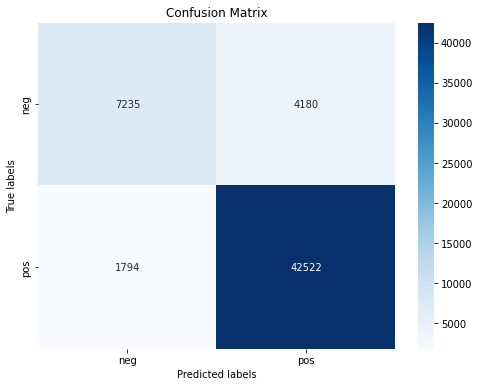

time: 347 ms (started: 2022-02-03 04:13:04 +00:00)


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

label_names = ["neg", "pos"]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.63      0.71     11415
           1       0.91      0.96      0.93     44316

    accuracy                           0.89     55731
   macro avg       0.86      0.80      0.82     55731
weighted avg       0.89      0.89      0.89     55731

time: 84.3 ms (started: 2022-02-03 04:13:09 +00:00)


In [37]:
from imblearn.over_sampling import SMOTE
def apply_smote(tfidf_matrix, y_train):
  smote = SMOTE(random_state=42)
  X_res, y_res = smote.fit_resample(tfidf_matrix, y_train)
  return X_res, y_res

time: 439 ms (started: 2022-02-03 03:55:09 +00:00)


In [39]:
from collections import Counter
print(f'Original dataset shape : {Counter(y_train)}')

Original dataset shape : Counter({1: 177262, 0: 45660})
time: 83.5 ms (started: 2022-02-03 03:55:55 +00:00)


In [40]:
X_res, y_res = apply_smote(train_tfidf_matrix, y_train)

time: 1min 12s (started: 2022-02-03 03:56:01 +00:00)


In [41]:
print(f'Resampled dataset shape {Counter(y_res)}')

Resampled dataset shape Counter({1: 177262, 0: 177262})
time: 85 ms (started: 2022-02-03 03:57:14 +00:00)


In [43]:
model2 = get_train_model(X_res, y_res)

time: 18.7 s (started: 2022-02-03 03:58:10 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [44]:
y_pred = get_y_pred(model2, test_tfidf_matrix)

time: 9.99 ms (started: 2022-02-03 03:59:17 +00:00)


Text(0.5, 1.0, 'Confusion Matrix')

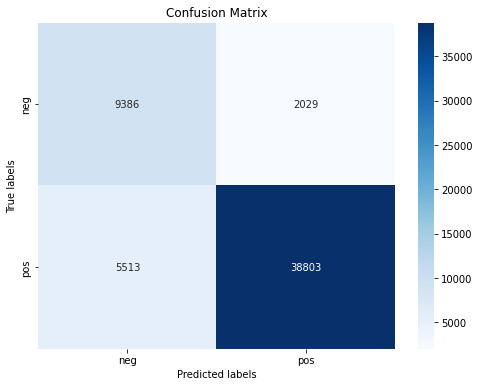

time: 765 ms (started: 2022-02-03 03:59:28 +00:00)


In [45]:
label_names = ["neg", "pos"]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=label_names, 
            yticklabels=label_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.82      0.71     11415
           1       0.95      0.88      0.91     44316

    accuracy                           0.86     55731
   macro avg       0.79      0.85      0.81     55731
weighted avg       0.88      0.86      0.87     55731

time: 155 ms (started: 2022-02-03 03:59:39 +00:00)


# Inferencing

In [47]:
def lemmatize_review(review):
    lemmatizer = nltk.WordNetLemmatizer()
    tokenized_lines = nltk.word_tokenize(review)
    for i in range(len(tokenized_lines)):
        lammatize_words = [
            lemmatizer.lemmatize(word).lower()
            for word in tokenized_lines
            if not word.lower() in set(stopwords.words("english"))
        ]
        return " ".join(lammatize_words)

time: 14.6 ms (started: 2022-02-03 04:04:13 +00:00)


In [53]:
import string
string.punctuation

def remove_punctuation(review):
  no_punct = [words.lower() for words in review if words not in string.punctuation]
  review_wo_punct= "".join(no_punct)
  return review_wo_punct

time: 8.34 ms (started: 2022-02-03 04:06:03 +00:00)


In [57]:
text1 = "This sweater is a bulky, fairly heavy winter sweater that will be awesome for the office or casual wear. The fabric is very silky soft. It's nice and snuggly! I can't wait for it to get cool enough to wear it!"

time: 1.17 ms (started: 2022-02-03 04:06:44 +00:00)


In [93]:
text2 = "I was disappointed with the Avoir Aime sequin dress. It was one of the first dresses I purchased from Amazon. The dress looks decent on, however, It ran a little short for my 5’5″ frame. The loop that closes the dress in the back also broke even before I could wear it out. The navy is also a bit off compared to the dark navy pictured on the model. The color difference didn’t really bother me, but the quality did. With the broken loop I ended up returning it and checking it as a LOSS."

time: 1.32 ms (started: 2022-02-03 04:21:58 +00:00)


In [94]:
text1_clean = lemmatize_review(text1)
text1_clean = remove_punctuation(text1_clean)

text2_clean = lemmatize_review(text2)
text2_clean = remove_punctuation(text2_clean)

time: 42.2 ms (started: 2022-02-03 04:22:15 +00:00)


In [99]:
infer_matrix_for_product_1 = create_test_matrix(tfidf_vectorizer, [text1_clean])

time: 15 ms (started: 2022-02-03 04:23:06 +00:00)


In [102]:
infer_matrix_for_product_2 = create_test_matrix(tfidf_vectorizer, [text2_clean])

time: 10.2 ms (started: 2022-02-03 04:23:27 +00:00)


In [100]:
infer_pred_for_product_1 = get_y_pred(model2, infer_matrix_for_product_1)

time: 4.35 ms (started: 2022-02-03 04:23:18 +00:00)


In [103]:
infer_pred_for_product_2 = get_y_pred(model2, infer_matrix_for_product_2)

time: 8.28 ms (started: 2022-02-03 04:23:36 +00:00)


In [104]:
def get_pos_neg(infer_prediction):
  if infer_prediction[0] == 1:
    return "pos"
  else:
    return "neg"

time: 1.92 ms (started: 2022-02-03 04:23:41 +00:00)


In [105]:
get_pos_neg(infer_pred_for_product_1)

'pos'

time: 13.4 ms (started: 2022-02-03 04:23:48 +00:00)


In [106]:
get_pos_neg(infer_pred_for_product_2)

'neg'

time: 21.7 ms (started: 2022-02-03 04:23:52 +00:00)
